In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV, VarianceThreshold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from imblearn.pipeline import Pipeline as imbpipeline


### Data Cleaning and Preparation: Combining mulitple sets and cleaning. 

In [82]:
beta=pd.read_pickle('data/nbaseasonstats')
beta.rename(columns={'Name':'PLAYER'}, inplace=True)
beta.head()

,SEASON,AGE,TEAM,LEAGUE,POS,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PLAYER
0,2020-21,19.0,GSW,NBA,C,39,27,21.4,4.9,9.4,...,1.4,4.4,5.8,0.7,0.3,0.9,1.5,3.1,11.5,James Wiseman
0,2020-21,19.0,DET,NBA,PG,26,18,25.8,2.7,7.7,...,0.2,2.4,2.7,5.3,1.0,0.4,3.2,2.2,6.8,Killian Hayes
0,2020-21,20.0,SAC,NBA,PG,58,20,30.1,5.0,10.7,...,0.7,2.3,3.0,5.3,1.3,0.5,1.6,1.4,13.0,Tyrese Haliburton
0,2020-21,19.0,CHO,NBA,PG,51,31,28.8,5.7,13.2,...,1.2,4.7,5.9,6.1,1.6,0.4,2.8,2.7,15.7,LaMelo Ball
0,2020-21,19.0,OKC,NBA,PF,45,28,24.2,3.1,9.1,...,0.7,4.0,4.7,2.2,0.4,0.9,2.2,1.3,8.2,Aleksej Pokusevski


In [83]:
beta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31120 entries, 0 to 0
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SEASON  31120 non-null  object 
 1   AGE     31097 non-null  float64
 2   TEAM    31120 non-null  object 
 3   LEAGUE  31120 non-null  object 
 4   POS     29961 non-null  object 
 5   G       31091 non-null  object 
 6   GS      22523 non-null  object 
 7   MP      30006 non-null  object 
 8   FG      31075 non-null  object 
 9   FGA     31073 non-null  object 
 10  FG%     30947 non-null  object 
 11  3P      24641 non-null  object 
 12  3PA     24641 non-null  object 
 13  3P%     20655 non-null  object 
 14  2P      26294 non-null  object 
 15  2PA     26294 non-null  object 
 16  2P%     26118 non-null  object 
 17  eFG%    26178 non-null  object 
 18  FT      31075 non-null  object 
 19  FTA     31075 non-null  object 
 20  FT%     30008 non-null  object 
 21  ORB     26356 non-null  object 
 22  DR

Creating a new season counter column. Then using this to filter seasons to third season stats of players. This is usually the year rookies take the 'rookie leap' and the stats we want to focus on. 

In [84]:
beta['SEASON_COUNT']=beta.groupby('PLAYER')['SEASON'].cumcount()+1
beta.head()


,SEASON,AGE,TEAM,LEAGUE,POS,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PLAYER,SEASON_COUNT
0,2020-21,19.0,GSW,NBA,C,39,27,21.4,4.9,9.4,...,4.4,5.8,0.7,0.3,0.9,1.5,3.1,11.5,James Wiseman,1
0,2020-21,19.0,DET,NBA,PG,26,18,25.8,2.7,7.7,...,2.4,2.7,5.3,1.0,0.4,3.2,2.2,6.8,Killian Hayes,1
0,2020-21,20.0,SAC,NBA,PG,58,20,30.1,5.0,10.7,...,2.3,3.0,5.3,1.3,0.5,1.6,1.4,13.0,Tyrese Haliburton,1
0,2020-21,19.0,CHO,NBA,PG,51,31,28.8,5.7,13.2,...,4.7,5.9,6.1,1.6,0.4,2.8,2.7,15.7,LaMelo Ball,1
0,2020-21,19.0,OKC,NBA,PF,45,28,24.2,3.1,9.1,...,4.0,4.7,2.2,0.4,0.9,2.2,1.3,8.2,Aleksej Pokusevski,1


In [85]:
threeseasons=beta[beta['SEASON_COUNT']<4]
threeseasons

,SEASON,AGE,TEAM,LEAGUE,POS,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PLAYER,SEASON_COUNT
0,2020-21,19.0,GSW,NBA,C,39,27,21.4,4.9,9.4,...,4.4,5.8,0.7,0.3,0.9,1.5,3.1,11.5,James Wiseman,1
0,2020-21,19.0,DET,NBA,PG,26,18,25.8,2.7,7.7,...,2.4,2.7,5.3,1.0,0.4,3.2,2.2,6.8,Killian Hayes,1
0,2020-21,20.0,SAC,NBA,PG,58,20,30.1,5.0,10.7,...,2.3,3.0,5.3,1.3,0.5,1.6,1.4,13.0,Tyrese Haliburton,1
0,2020-21,19.0,CHO,NBA,PG,51,31,28.8,5.7,13.2,...,4.7,5.9,6.1,1.6,0.4,2.8,2.7,15.7,LaMelo Ball,1
0,2020-21,19.0,OKC,NBA,PF,45,28,24.2,3.1,9.1,...,4.0,4.7,2.2,0.4,0.9,2.2,1.3,8.2,Aleksej Pokusevski,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1970-71,22.0,MIL,NBA,PG,53,NaN,7.5,0.9,2.5,...,NaN,0.9,1.4,NaN,NaN,NaN,0.6,2.2,Bill Zopf,1
0,2016-17,19.0,LAL,NBA,C,38.0,11.0,16.0,3.3,6.3,...,3.1,4.2,0.8,0.4,0.9,0.8,1.7,7.5,Ivica Zubac,1
1,2017-18,20.0,LAL,NBA,C,43.0,0.0,9.5,1.4,2.8,...,1.8,2.9,0.6,0.2,0.3,0.6,1.1,3.7,Ivica Zubac,2
2,2018-19,21.0,TOT,NBA,C,59.0,37.0,17.6,3.6,6.4,...,4.2,6.1,1.1,0.2,0.9,1.2,2.3,8.9,Ivica Zubac,3


Filter and remove young players as separate dataset not to be included in any testing or train set. These players are to young to be qualified for All-NBA team this far in their career. Can run projections on these players later. 

In [215]:
youngplayers = threeseasons[(threeseasons['SEASON_COUNT'] <3) & (threeseasons['SEASON'].isin(['2020-21','2019-20','2018-19'])) ]

In [87]:
youngplayers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539 entries, 0 to 1
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SEASON        539 non-null    object 
 1   AGE           539 non-null    float64
 2   TEAM          539 non-null    object 
 3   LEAGUE        539 non-null    object 
 4   POS           539 non-null    object 
 5   G             539 non-null    object 
 6   GS            539 non-null    object 
 7   MP            539 non-null    object 
 8   FG            539 non-null    object 
 9   FGA           539 non-null    object 
 10  FG%           533 non-null    object 
 11  3P            539 non-null    object 
 12  3PA           539 non-null    object 
 13  3P%           492 non-null    object 
 14  2P            539 non-null    object 
 15  2PA           539 non-null    object 
 16  2P%           524 non-null    object 
 17  eFG%          533 non-null    object 
 18  FT            539 non-null    ob

In [88]:
finalexp=pd.concat([threeseasons, youngplayers, youngplayers]).drop_duplicates(keep=False)

In [89]:
finalexp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10824 entries, 2 to 0
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SEASON        10824 non-null  object 
 1   AGE           10801 non-null  float64
 2   TEAM          10824 non-null  object 
 3   LEAGUE        10824 non-null  object 
 4   POS           9927 non-null   object 
 5   G             10817 non-null  object 
 6   GS            6749 non-null   object 
 7   MP            9984 non-null   object 
 8   FG            10816 non-null  object 
 9   FGA           10815 non-null  object 
 10  FG%           10747 non-null  object 
 11  3P            7732 non-null   object 
 12  3PA           7732 non-null   object 
 13  3P%           6254 non-null   object 
 14  2P            8471 non-null   object 
 15  2PA           8471 non-null   object 
 16  2P%           8392 non-null   object 
 17  eFG%          8412 non-null   object 
 18  FT            10816 non-null  

In [90]:
finalexp.head()

,SEASON,AGE,TEAM,LEAGUE,POS,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PLAYER,SEASON_COUNT
2,2020-21,19.0,ORL,NBA,SG,26.0,1.0,25.2,4.3,9.7,...,4.2,5.0,2.8,0.6,0.3,1.6,1.5,11.2,R.J. Hampton,3
2,2020-21,22.0,PHI,NBA,SG,6.0,0.0,4.5,0.8,1.5,...,0.2,0.7,0.5,0.2,0.0,0.2,0.3,2.7,Mason Jones,3
2,2020-21,24.0,CLE,NBA,SG,28.0,1.0,13.4,1.3,3.6,...,1.5,1.8,0.9,0.5,0.3,0.6,1.3,4.1,Brodric Thomas,3
0,1990-91,22.0,POR,NBA,PF,43.0,0.0,6.7,1.3,2.7,...,1.4,2.1,0.3,0.1,0.3,0.5,0.9,3.1,Alaa Abdelnaby,1
1,1991-92,23.0,POR,NBA,PF,71.0,1.0,13.2,2.5,5.1,...,2.5,3.7,0.4,0.4,0.2,0.9,1.9,6.1,Alaa Abdelnaby,2


Filtering out third year rookie leap season for projections. 

In [91]:
thirdseason=finalexp[finalexp['SEASON_COUNT']==3]
thirdseason

,SEASON,AGE,TEAM,LEAGUE,POS,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PLAYER,SEASON_COUNT
2,2020-21,19.0,ORL,NBA,SG,26.0,1.0,25.2,4.3,9.7,...,4.2,5.0,2.8,0.6,0.3,1.6,1.5,11.2,R.J. Hampton,3
2,2020-21,22.0,PHI,NBA,SG,6.0,0.0,4.5,0.8,1.5,...,0.2,0.7,0.5,0.2,0.0,0.2,0.3,2.7,Mason Jones,3
2,2020-21,24.0,CLE,NBA,SG,28.0,1.0,13.4,1.3,3.6,...,1.5,1.8,0.9,0.5,0.3,0.6,1.3,4.1,Brodric Thomas,3
2,1992-93,24.0,TOT,NBA,PF,75.0,52.0,17.5,3.3,6.3,...,2.8,4.5,0.4,0.3,0.3,1.3,2.5,7.7,Alaa Abdelnaby,3
2,1968-69,22.0,MIL,NBA,C,29.0,NaN,28.9,4.3,12.0,...,NaN,13.0,1.1,NaN,NaN,NaN,3.4,11.0,Zaid Abdul-Aziz,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,2014-15,25.0,BOS,NBA,C,82.0,59.0,21.1,4.1,7.5,...,3.9,5.7,1.4,0.2,0.6,0.9,2.5,10.2,Tyler Zeller,3
2,2002-03,25.0,LAC,NBA,C,41.0,1.0,10.0,1.5,4.0,...,1.2,1.9,0.2,0.2,0.2,0.8,1.0,4.4,Wang Zhizhi,3
2,1996-97,23.0,CHH,NBA,C,36.0,2.0,8.0,0.9,2.4,...,1.1,1.8,0.3,0.1,0.1,0.6,1.2,2.5,George Zidek,3
2,2019-20,23.0,CLE,NBA,C,22,0,10.0,1.9,3.3,...,2.2,3.0,0.3,0.3,0.2,0.5,1.2,4.4,Ante Zizic,3


Adding ALL_NBA TEAM DATA FROM OTHER SETS

In [92]:
df_nba = pd.read_csv('data/allnb1', header=None)
df_drop=df_nba.drop(columns=[0,2,3,4,5,6,7,8]).drop_duplicates(subset=[1])
df_drop.columns = df_drop.iloc[0]
df_drop=df_drop.iloc[1:, :]
df_drop['1ST_TEAMNBA']=1
df_drop

,PLAYER,1ST_TEAMNBA
1,LeBron James,1
2,James Harden,1
3,Anthony Davis,1
4,Giannis Antetokounmpo,1
5,Luka Doncic,1
...,...,...
362,Howie Dallmar,1
363,Bob Feerick,1
365,Ed Sadowski,1
369,Bones McKinney,1


In [93]:
dfx=pd.merge(thirdseason,df_drop,how='left')
dfx

,SEASON,AGE,TEAM,LEAGUE,POS,G,GS,MP,FG,FGA,...,TRB,AST,STL,BLK,TOV,PF,PTS,PLAYER,SEASON_COUNT,1ST_TEAMNBA
0,2020-21,19.0,ORL,NBA,SG,26.0,1.0,25.2,4.3,9.7,...,5.0,2.8,0.6,0.3,1.6,1.5,11.2,R.J. Hampton,3,NaN
1,2020-21,22.0,PHI,NBA,SG,6.0,0.0,4.5,0.8,1.5,...,0.7,0.5,0.2,0.0,0.2,0.3,2.7,Mason Jones,3,NaN
2,2020-21,24.0,CLE,NBA,SG,28.0,1.0,13.4,1.3,3.6,...,1.8,0.9,0.5,0.3,0.6,1.3,4.1,Brodric Thomas,3,NaN
3,1992-93,24.0,TOT,NBA,PF,75.0,52.0,17.5,3.3,6.3,...,4.5,0.4,0.3,0.3,1.3,2.5,7.7,Alaa Abdelnaby,3,NaN
4,1968-69,22.0,MIL,NBA,C,29.0,NaN,28.9,4.3,12.0,...,13.0,1.1,NaN,NaN,NaN,3.4,11.0,Zaid Abdul-Aziz,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3076,2014-15,25.0,BOS,NBA,C,82.0,59.0,21.1,4.1,7.5,...,5.7,1.4,0.2,0.6,0.9,2.5,10.2,Tyler Zeller,3,NaN
3077,2002-03,25.0,LAC,NBA,C,41.0,1.0,10.0,1.5,4.0,...,1.9,0.2,0.2,0.2,0.8,1.0,4.4,Wang Zhizhi,3,NaN
3078,1996-97,23.0,CHH,NBA,C,36.0,2.0,8.0,0.9,2.4,...,1.8,0.3,0.1,0.1,0.6,1.2,2.5,George Zidek,3,NaN
3079,2019-20,23.0,CLE,NBA,C,22,0,10.0,1.9,3.3,...,3.0,0.3,0.3,0.2,0.5,1.2,4.4,Ante Zizic,3,NaN


In [94]:
df2 = pd.read_csv('data/allnba2', header=None)
df_drop2=df2.drop(columns=[0,2,3,4,5,6,7,8]).drop_duplicates(subset=[1])
df_drop2.columns = df_drop2.iloc[0]
df_drop2=df_drop2.iloc[1:, :]
df_drop2['2nd_TEAMNBA']=1
df_drop2

,PLAYER,2nd_TEAMNBA
1,Chris Paul,1
2,Kawhi Leonard,1
3,Damian Lillard,1
4,Nikola Jokic,1
5,Pascal Siakam,1
...,...,...
363,Stan Miasek,1
364,Fred Scolari,1
365,Frankie Baumholtz,1
366,Ernie Calverley,1


In [95]:
df3 = pd.read_csv('data/allnba3', header=None)
df_drop3=df3.drop(columns=[0,2,3,4,5,6,7,8]).drop_duplicates(subset=[1])
df_drop3.columns = df_drop3.iloc[0]
df_drop3=df_drop3.iloc[1:, :]
df_drop3['3rd_TEAMNBA']=1
df_drop3

,PLAYER,3rd_TEAMNBA
1,Russell Westbrook,1
2,Jimmy Butler,1
3,Rudy Gobert,1
4,Ben Simmons,1
5,Jayson Tatum,1
...,...,...
150,Bernard King,1
151,Chris Mullin,1
156,Terry Cummings,1
157,Dale Ellis,1


In [96]:
dfy=pd.merge(dfx,df_drop2,how='left')
dfz=pd.merge(dfy,df_drop3,how='left')
dfz

,SEASON,AGE,TEAM,LEAGUE,POS,G,GS,MP,FG,FGA,...,STL,BLK,TOV,PF,PTS,PLAYER,SEASON_COUNT,1ST_TEAMNBA,2nd_TEAMNBA,3rd_TEAMNBA
0,2020-21,19.0,ORL,NBA,SG,26.0,1.0,25.2,4.3,9.7,...,0.6,0.3,1.6,1.5,11.2,R.J. Hampton,3,NaN,NaN,NaN
1,2020-21,22.0,PHI,NBA,SG,6.0,0.0,4.5,0.8,1.5,...,0.2,0.0,0.2,0.3,2.7,Mason Jones,3,NaN,NaN,NaN
2,2020-21,24.0,CLE,NBA,SG,28.0,1.0,13.4,1.3,3.6,...,0.5,0.3,0.6,1.3,4.1,Brodric Thomas,3,NaN,NaN,NaN
3,1992-93,24.0,TOT,NBA,PF,75.0,52.0,17.5,3.3,6.3,...,0.3,0.3,1.3,2.5,7.7,Alaa Abdelnaby,3,NaN,NaN,NaN
4,1968-69,22.0,MIL,NBA,C,29.0,NaN,28.9,4.3,12.0,...,NaN,NaN,NaN,3.4,11.0,Zaid Abdul-Aziz,3,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3076,2014-15,25.0,BOS,NBA,C,82.0,59.0,21.1,4.1,7.5,...,0.2,0.6,0.9,2.5,10.2,Tyler Zeller,3,NaN,NaN,NaN
3077,2002-03,25.0,LAC,NBA,C,41.0,1.0,10.0,1.5,4.0,...,0.2,0.2,0.8,1.0,4.4,Wang Zhizhi,3,NaN,NaN,NaN
3078,1996-97,23.0,CHH,NBA,C,36.0,2.0,8.0,0.9,2.4,...,0.1,0.1,0.6,1.2,2.5,George Zidek,3,NaN,NaN,NaN
3079,2019-20,23.0,CLE,NBA,C,22,0,10.0,1.9,3.3,...,0.3,0.2,0.5,1.2,4.4,Ante Zizic,3,NaN,NaN,NaN


In [97]:
values = {"1ST_TEAMNBA": 0, "2nd_TEAMNBA": 0, "3rd_TEAMNBA": 0}
df_final=dfz.fillna(value=values)
df_final

,SEASON,AGE,TEAM,LEAGUE,POS,G,GS,MP,FG,FGA,...,STL,BLK,TOV,PF,PTS,PLAYER,SEASON_COUNT,1ST_TEAMNBA,2nd_TEAMNBA,3rd_TEAMNBA
0,2020-21,19.0,ORL,NBA,SG,26.0,1.0,25.2,4.3,9.7,...,0.6,0.3,1.6,1.5,11.2,R.J. Hampton,3,0.0,0.0,0.0
1,2020-21,22.0,PHI,NBA,SG,6.0,0.0,4.5,0.8,1.5,...,0.2,0.0,0.2,0.3,2.7,Mason Jones,3,0.0,0.0,0.0
2,2020-21,24.0,CLE,NBA,SG,28.0,1.0,13.4,1.3,3.6,...,0.5,0.3,0.6,1.3,4.1,Brodric Thomas,3,0.0,0.0,0.0
3,1992-93,24.0,TOT,NBA,PF,75.0,52.0,17.5,3.3,6.3,...,0.3,0.3,1.3,2.5,7.7,Alaa Abdelnaby,3,0.0,0.0,0.0
4,1968-69,22.0,MIL,NBA,C,29.0,NaN,28.9,4.3,12.0,...,NaN,NaN,NaN,3.4,11.0,Zaid Abdul-Aziz,3,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3076,2014-15,25.0,BOS,NBA,C,82.0,59.0,21.1,4.1,7.5,...,0.2,0.6,0.9,2.5,10.2,Tyler Zeller,3,0.0,0.0,0.0
3077,2002-03,25.0,LAC,NBA,C,41.0,1.0,10.0,1.5,4.0,...,0.2,0.2,0.8,1.0,4.4,Wang Zhizhi,3,0.0,0.0,0.0
3078,1996-97,23.0,CHH,NBA,C,36.0,2.0,8.0,0.9,2.4,...,0.1,0.1,0.6,1.2,2.5,George Zidek,3,0.0,0.0,0.0
3079,2019-20,23.0,CLE,NBA,C,22,0,10.0,1.9,3.3,...,0.3,0.2,0.5,1.2,4.4,Ante Zizic,3,0.0,0.0,0.0


In [98]:
#Create binary variable fi players has been on any  All-NBA team or not. 
df_final['target'] = (df_final['1ST_TEAMNBA'] + df_final['2nd_TEAMNBA']+df_final['3rd_TEAMNBA']) > 0
df_final

,SEASON,AGE,TEAM,LEAGUE,POS,G,GS,MP,FG,FGA,...,BLK,TOV,PF,PTS,PLAYER,SEASON_COUNT,1ST_TEAMNBA,2nd_TEAMNBA,3rd_TEAMNBA,target
0,2020-21,19.0,ORL,NBA,SG,26.0,1.0,25.2,4.3,9.7,...,0.3,1.6,1.5,11.2,R.J. Hampton,3,0.0,0.0,0.0,False
1,2020-21,22.0,PHI,NBA,SG,6.0,0.0,4.5,0.8,1.5,...,0.0,0.2,0.3,2.7,Mason Jones,3,0.0,0.0,0.0,False
2,2020-21,24.0,CLE,NBA,SG,28.0,1.0,13.4,1.3,3.6,...,0.3,0.6,1.3,4.1,Brodric Thomas,3,0.0,0.0,0.0,False
3,1992-93,24.0,TOT,NBA,PF,75.0,52.0,17.5,3.3,6.3,...,0.3,1.3,2.5,7.7,Alaa Abdelnaby,3,0.0,0.0,0.0,False
4,1968-69,22.0,MIL,NBA,C,29.0,NaN,28.9,4.3,12.0,...,NaN,NaN,3.4,11.0,Zaid Abdul-Aziz,3,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3076,2014-15,25.0,BOS,NBA,C,82.0,59.0,21.1,4.1,7.5,...,0.6,0.9,2.5,10.2,Tyler Zeller,3,0.0,0.0,0.0,False
3077,2002-03,25.0,LAC,NBA,C,41.0,1.0,10.0,1.5,4.0,...,0.2,0.8,1.0,4.4,Wang Zhizhi,3,0.0,0.0,0.0,False
3078,1996-97,23.0,CHH,NBA,C,36.0,2.0,8.0,0.9,2.4,...,0.1,0.6,1.2,2.5,George Zidek,3,0.0,0.0,0.0,False
3079,2019-20,23.0,CLE,NBA,C,22,0,10.0,1.9,3.3,...,0.2,0.5,1.2,4.4,Ante Zizic,3,0.0,0.0,0.0,False


In [99]:
#change target of ALL_NBA PLAYERS OR NOT TO binary

df_final['target'] = df_final['target'].astype(int)
df_final

,SEASON,AGE,TEAM,LEAGUE,POS,G,GS,MP,FG,FGA,...,BLK,TOV,PF,PTS,PLAYER,SEASON_COUNT,1ST_TEAMNBA,2nd_TEAMNBA,3rd_TEAMNBA,target
0,2020-21,19.0,ORL,NBA,SG,26.0,1.0,25.2,4.3,9.7,...,0.3,1.6,1.5,11.2,R.J. Hampton,3,0.0,0.0,0.0,0
1,2020-21,22.0,PHI,NBA,SG,6.0,0.0,4.5,0.8,1.5,...,0.0,0.2,0.3,2.7,Mason Jones,3,0.0,0.0,0.0,0
2,2020-21,24.0,CLE,NBA,SG,28.0,1.0,13.4,1.3,3.6,...,0.3,0.6,1.3,4.1,Brodric Thomas,3,0.0,0.0,0.0,0
3,1992-93,24.0,TOT,NBA,PF,75.0,52.0,17.5,3.3,6.3,...,0.3,1.3,2.5,7.7,Alaa Abdelnaby,3,0.0,0.0,0.0,0
4,1968-69,22.0,MIL,NBA,C,29.0,NaN,28.9,4.3,12.0,...,NaN,NaN,3.4,11.0,Zaid Abdul-Aziz,3,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3076,2014-15,25.0,BOS,NBA,C,82.0,59.0,21.1,4.1,7.5,...,0.6,0.9,2.5,10.2,Tyler Zeller,3,0.0,0.0,0.0,0
3077,2002-03,25.0,LAC,NBA,C,41.0,1.0,10.0,1.5,4.0,...,0.2,0.8,1.0,4.4,Wang Zhizhi,3,0.0,0.0,0.0,0
3078,1996-97,23.0,CHH,NBA,C,36.0,2.0,8.0,0.9,2.4,...,0.1,0.6,1.2,2.5,George Zidek,3,0.0,0.0,0.0,0
3079,2019-20,23.0,CLE,NBA,C,22,0,10.0,1.9,3.3,...,0.2,0.5,1.2,4.4,Ante Zizic,3,0.0,0.0,0.0,0


In [100]:
df_final.isna().sum()

SEASON             0
AGE                2
TEAM               0
LEAGUE             0
POS              162
G                  4
GS              1006
MP               176
FG                 5
FGA                6
FG%               20
3P               766
3PA              766
3P%             1158
2P               569
2PA              569
2P%              589
eFG%             582
FT                 5
FTA                5
FT%              128
ORB              591
DRB              593
TRB              148
AST                6
STL              739
BLK              735
TOV              691
PF                 5
PTS                5
PLAYER             0
SEASON_COUNT       0
1ST_TEAMNBA        0
2nd_TEAMNBA        0
3rd_TEAMNBA        0
target             0
dtype: int64

In [101]:
df_final.POS.value_counts().to_dict()

{'PF': 561,
 'SG': 554,
 'SF': 554,
 'PG': 510,
 'C': 491,
 'Did Not Play\xa0(other pro league—CBA)': 28,
 'Did Not Play\xa0(other pro league—Italy)': 21,
 'SF,SG': 16,
 'Did Not Play\xa0(other pro league—Spain)': 16,
 'PF,SF': 9,
 'Did Not Play\xa0(other pro league—Israel)': 8,
 'PG,SG': 7,
 'C,PF': 7,
 'Did Not Play\xa0(injury—knee)': 6,
 'Did Not Play\xa0(other pro league—ABL)': 6,
 'Did Not Play\xa0(military service—U.S. Army)': 6,
 'Did Not Play\xa0(other pro league—Greece)': 5,
 'Did Not Play\xa0(other pro league—France)': 4,
 'Did Not Play\xa0(other pro league—D-League)': 4,
 'Did Not Play\xa0(other pro league—NPBL)': 4,
 'Did Not Play\xa0(other pro league—NABL)': 4,
 'Did Not Play\xa0(retired)': 3,
 'Did Not Play': 3,
 'Did Not Play\xa0(other pro league—EPBL)': 3,
 'Did Not Play\xa0(injury—back)': 3,
 'Did Not Play\xa0(suspended—substance abuse)': 2,
 'Did Not Play\xa0(other pro league—EBA)': 2,
 'Did Not Play\xa0(other pro league—Australia)': 2,
 'Did Not Play\xa0(waived)': 2,

In [102]:
df_final.TEAM.value_counts().to_dict()

{'TOT': 296,
 'NYK': 105,
 'BOS': 102,
 'CHI': 91,
 'CLE': 84,
 'DET': 83,
 'PHI': 83,
 'ATL': 82,
 'MIL': 80,
 'POR': 80,
 'PHO': 79,
 'IND': 74,
 'HOU': 73,
 'GSW': 73,
 'LAL': 70,
 'LAC': 69,
 'DEN': 69,
 'DAL': 67,
 'UTA': 64,
 'SAS': 61,
 'MIA': 55,
 'SEA': 55,
 'MIN': 51,
 'SAC': 49,
 'TOR': 47,
 'NJN': 44,
 'ORL': 41,
 'WSB': 37,
 'PHW': 36,
 'WAS': 35,
 'MEM': 31,
 'Did Not Play\xa0(other pro league—CBA)': 28,
 'CIN': 24,
 'FTW': 24,
 'MNL': 21,
 'Did Not Play\xa0(other pro league—Italy)': 21,
 'BLB': 20,
 'NYA': 20,
 'OKC': 20,
 'CHH': 19,
 'KEN': 19,
 'BRK': 18,
 'SYR': 18,
 'ROC': 18,
 'Did Not Play\xa0(other pro league—Spain)': 16,
 'STL': 15,
 'DLC': 15,
 'SFW': 15,
 'NOH': 15,
 'CHA': 15,
 'NOJ': 12,
 'DNR': 12,
 'BAL': 11,
 'BUF': 11,
 'INA': 11,
 'NOP': 11,
 'KCK': 11,
 'PRO': 10,
 'WSC': 10,
 'SDR': 10,
 'VIR': 10,
 'MLH': 9,
 'VAN': 9,
 'STB': 9,
 'SAA': 8,
 'Did Not Play\xa0(other pro league—Israel)': 8,
 'CHS': 8,
 'SSL': 7,
 'CHO': 7,
 'TRH': 7,
 'NOB': 7,
 'MMP': 

Many players in nba are drafted and do not end up playing or getting waived. As we can see we unfortunetely have to drop them from the dataset as they do not play in the NBA though they were tracked. 

In [103]:
df=df_final[df_final['POS'].isin(['PG','SG','SF','PF','C'])]

In [104]:
df.head()

,SEASON,AGE,TEAM,LEAGUE,POS,G,GS,MP,FG,FGA,...,BLK,TOV,PF,PTS,PLAYER,SEASON_COUNT,1ST_TEAMNBA,2nd_TEAMNBA,3rd_TEAMNBA,target
0,2020-21,19.0,ORL,NBA,SG,26.0,1.0,25.2,4.3,9.7,...,0.3,1.6,1.5,11.2,R.J. Hampton,3,0.0,0.0,0.0,0
1,2020-21,22.0,PHI,NBA,SG,6.0,0.0,4.5,0.8,1.5,...,0.0,0.2,0.3,2.7,Mason Jones,3,0.0,0.0,0.0,0
2,2020-21,24.0,CLE,NBA,SG,28.0,1.0,13.4,1.3,3.6,...,0.3,0.6,1.3,4.1,Brodric Thomas,3,0.0,0.0,0.0,0
3,1992-93,24.0,TOT,NBA,PF,75.0,52.0,17.5,3.3,6.3,...,0.3,1.3,2.5,7.7,Alaa Abdelnaby,3,0.0,0.0,0.0,0
4,1968-69,22.0,MIL,NBA,C,29.0,NaN,28.9,4.3,12.0,...,NaN,NaN,3.4,11.0,Zaid Abdul-Aziz,3,0.0,0.0,0.0,0


### Exploratory Data Analysis and Cleaning of filtered players. 

In [105]:
#Counting unique values for each column
for col in df.columns:
    try:
        print(col, df[col].nunique())
    except:
        print(col, df[col].nunique())   
    print('\n')

SEASON 73


AGE 15


TEAM 94


LEAGUE 4


POS 5


G 170


GS 160


MP 702


FG 212


FGA 402


FG% 598


3P 52


3PA 125


3P% 405


2P 201


2PA 365


2P% 542


eFG% 558


FT 151


FTA 180


FT% 680


ORB 99


DRB 182


TRB 269


AST 176


STL 60


BLK 67


TOV 89


PF 91


PTS 467


PLAYER 2670


SEASON_COUNT 1


1ST_TEAMNBA 2


2nd_TEAMNBA 2


3rd_TEAMNBA 2


target 2




In [106]:
#Counting values for each column
for col in df_final.columns:
    try:
        print(col, df[col].value_counts())
    except:
        print(col, df[col].value_counts())   
    print('\n')

SEASON 2019-20    68
1969-70    63
2014-15    61
2010-11    59
2017-18    57
           ..
1963-64    11
1960-61    11
1959-60    10
1949-50    10
1948-49     9
Name: SEASON, Length: 73, dtype: int64


AGE 24.0    877
25.0    553
23.0    417
22.0    280
26.0    215
21.0    114
27.0     93
28.0     42
29.0     28
20.0     20
30.0     18
31.0      6
19.0      4
34.0      1
37.0      1
Name: AGE, dtype: int64


TEAM TOT    248
CHI     91
NYK     89
BOS     84
CLE     84
      ... 
AND      1
WAT      1
CAP      1
MMS      1
NOK      1
Name: TEAM, Length: 94, dtype: int64


LEAGUE NBA    2462
ABA     196
BAA       9
TOT       3
Name: LEAGUE, dtype: int64


POS PF    561
SG    554
SF    554
PG    510
C     491
Name: POS, dtype: int64


G 82.0    158
80.0     90
81.0     77
79.0     77
82       61
       ... 
39        2
51        2
87.0      1
28        1
43        1
Name: G, Length: 170, dtype: int64


GS 0.0     421
0       126
1.0      90
2        62
82.0     49
       ... 
34.0      1
5

In [107]:
df.dtypes

SEASON           object
AGE             float64
TEAM             object
LEAGUE           object
POS              object
G                object
GS               object
MP               object
FG               object
FGA              object
FG%              object
3P               object
3PA              object
3P%              object
2P               object
2PA              object
2P%              object
eFG%             object
FT               object
FTA              object
FT%              object
ORB              object
DRB              object
TRB              object
AST              object
STL              object
BLK              object
TOV              object
PF               object
PTS              object
PLAYER           object
SEASON_COUNT      int64
1ST_TEAMNBA     float64
2nd_TEAMNBA     float64
3rd_TEAMNBA     float64
target            int32
dtype: object

Most numerical columns are object need to be changed. 
Keep season,league, position, as categorical values.
Need to drop Player name colummn. Done in next few rows:


In [108]:
df=df.drop('PLAYER',axis=1)

In [109]:
numero=['AGE','G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS','SEASON_COUNT',
       'target']
from pandas import to_numeric

In [110]:
df[numero]=df[numero].apply(pd.to_numeric, errors='coerce')

In [111]:
df.dtypes

SEASON           object
AGE             float64
TEAM             object
LEAGUE           object
POS              object
G               float64
GS              float64
MP              float64
FG              float64
FGA             float64
FG%             float64
3P              float64
3PA             float64
3P%             float64
2P              float64
2PA             float64
2P%             float64
eFG%            float64
FT              float64
FTA             float64
FT%             float64
ORB             float64
DRB             float64
TRB             float64
AST             float64
STL             float64
BLK             float64
TOV             float64
PF              float64
PTS             float64
SEASON_COUNT      int64
1ST_TEAMNBA     float64
2nd_TEAMNBA     float64
3rd_TEAMNBA     float64
target            int32
dtype: object

In [112]:
df.isna().sum()

SEASON            0
AGE               1
TEAM              0
LEAGUE            0
POS               0
G                 3
GS              834
MP               37
FG                4
FGA               5
FG%              18
3P              570
3PA             570
3P%             955
2P              378
2PA             378
2P%             398
eFG%            391
FT                4
FTA               4
FT%             122
ORB             400
DRB             401
TRB              25
AST               5
STL             529
BLK             528
TOV             497
PF                4
PTS               4
SEASON_COUNT      0
1ST_TEAMNBA       0
2nd_TEAMNBA       0
3rd_TEAMNBA       0
target            0
dtype: int64

In [113]:
#Columns of low number of null values/missing that can be substituted as mean or median
low_null= ['G', 'MP', 'FG', 'FGA',
       'FG%', '3P', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',]

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
df.head()

,SEASON,AGE,TEAM,LEAGUE,POS,G,GS,MP,FG,FGA,...,STL,BLK,TOV,PF,PTS,SEASON_COUNT,1ST_TEAMNBA,2nd_TEAMNBA,3rd_TEAMNBA,target
0,2020-21,19.0,ORL,NBA,SG,26.0,1.0,25.2,4.3,9.7,...,0.6,0.3,1.6,1.5,11.2,3,0.0,0.0,0.0,0
1,2020-21,22.0,PHI,NBA,SG,6.0,0.0,4.5,0.8,1.5,...,0.2,0.0,0.2,0.3,2.7,3,0.0,0.0,0.0,0
2,2020-21,24.0,CLE,NBA,SG,28.0,1.0,13.4,1.3,3.6,...,0.5,0.3,0.6,1.3,4.1,3,0.0,0.0,0.0,0
3,1992-93,24.0,TOT,NBA,PF,75.0,52.0,17.5,3.3,6.3,...,0.3,0.3,1.3,2.5,7.7,3,0.0,0.0,0.0,0
4,1968-69,22.0,MIL,NBA,C,29.0,NaN,28.9,4.3,12.0,...,NaN,NaN,NaN,3.4,11.0,3,0.0,0.0,0.0,0


In [116]:
dfeda=df.copy()

In [117]:
dfeda['target']=dfeda['target'].map({1:'All-NBA TEAM', 0:'NO-TEAM'})

<ipython-input-118-67790e041fd7>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=counts.index, rotation=80);


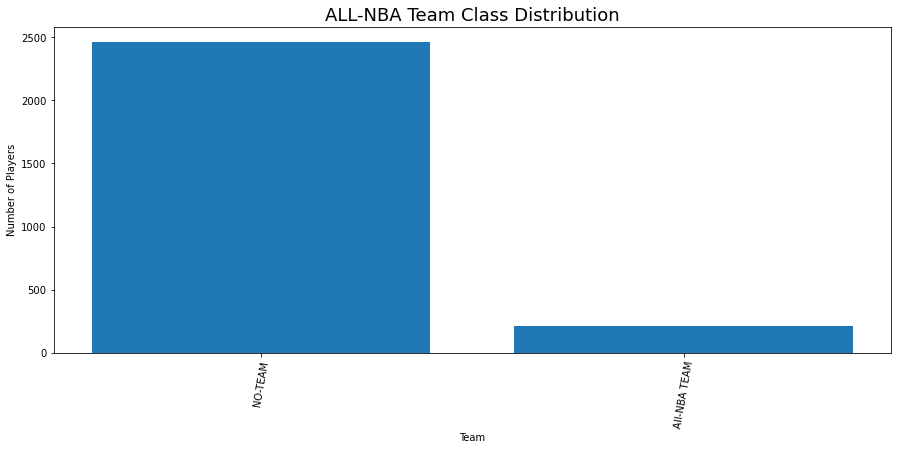

In [118]:
#Analysis to see most popular genres produced.
counts = dfeda['target'].value_counts()


fig, ax = plt.subplots(figsize=(15, 6))

plt.title('ALL-NBA Team Class Distribution',fontsize=18)
plt.xlabel('Team')
plt.ylabel('Number of Players')

ax.bar(x=counts.index, height=counts)
ax.set_xticklabels(labels=counts.index, rotation=80);

<ipython-input-119-6bc9e3fee61c>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=counts_.index, rotation=80);


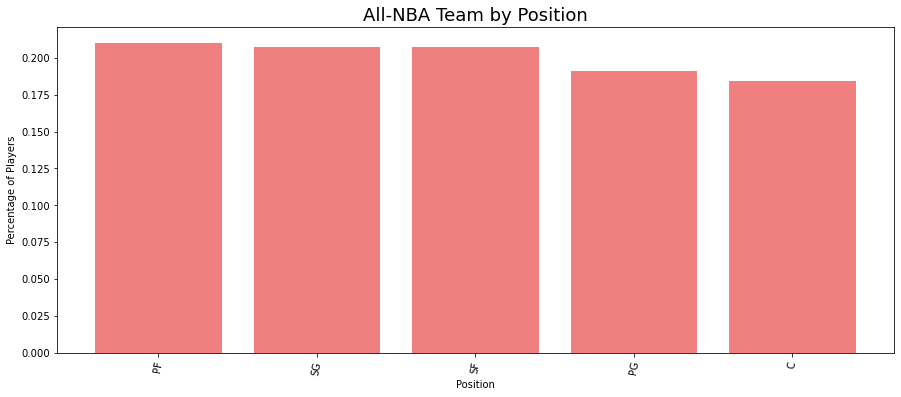

In [119]:
counts_ = dfeda['POS'].value_counts(normalize=True)

colors=['steelblue'] *22
colors[0:5]=['lightcoral']*5

fig, ax = plt.subplots(figsize=(15, 6))

plt.title('All-NBA Team by Position',fontsize=18)
plt.xlabel('Position')
plt.ylabel('Percentage of Players')

ax.bar(x=counts_.index, height=counts_,color=colors)
ax.set_xticklabels(labels=counts_.index, rotation=80);

<AxesSubplot:ylabel='target'>

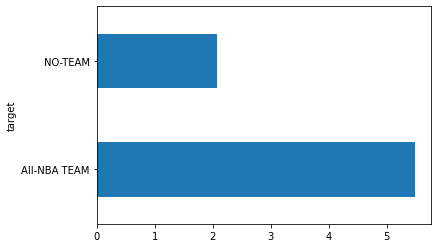

In [120]:
dfeda.groupby('target')['FTA'].mean().plot.barh()

In [121]:
dfeda.groupby('target')['FTA'].value_counts().sort_values(ascending=False)

target        FTA 
NO-TEAM       0.0     117
              1.0     101
              0.8      92
              0.7      90
              0.9      87
                     ... 
All-NBA TEAM  11.4      1
              11.8      1
              11.9      1
              17.0      1
NO-TEAM       11.3      1
Name: FTA, Length: 171, dtype: int64

<ipython-input-122-7ebffba0d422>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=by_genre.index, rotation=80);


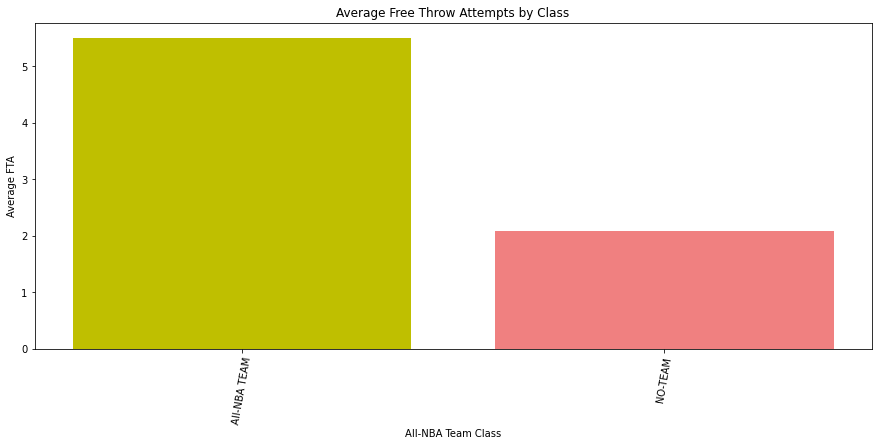

In [122]:
by_genre=dfeda.groupby('target')['FTA'].mean()

fig, ax = plt.subplots(figsize=(15, 6))

colors2=['steelblue']*26
colors2[0]='y'
colors2[1]='lightcoral'

colors2

plt.title('Average Free Throw Attempts by Class')
plt.xlabel('All-NBA Team Class')
plt.ylabel('Average FTA')
ax.bar(x=by_genre.index, height=by_genre,color=colors2)
ax.set_xticklabels(labels=by_genre.index, rotation=80);

<ipython-input-123-0415a6967c3b>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=by_genre.index, rotation=80);


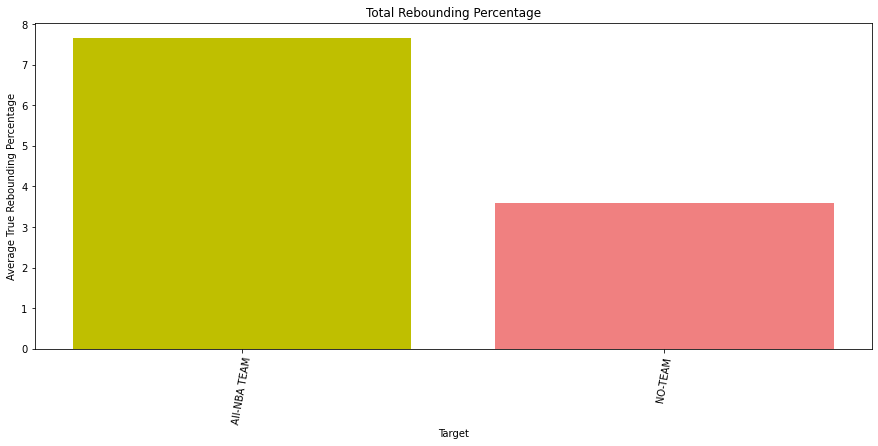

In [123]:
by_genre=dfeda.groupby('target')['TRB'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15, 6))

colors2=['steelblue']*26
colors2[0]='y'
colors2[1]='lightcoral'
colors2[11]='lightcoral'
colors2[17]='lightcoral'
colors2[22]='lightcoral'
colors2

plt.title('Total Rebounding Percentage')
plt.xlabel('Target')
plt.ylabel('Average True Rebounding Percentage')
ax.bar(x=by_genre.index, height=by_genre,color=colors2)
ax.set_xticklabels(labels=by_genre.index, rotation=80);

Text(0, 0.5, 'Free Throw Attempts')

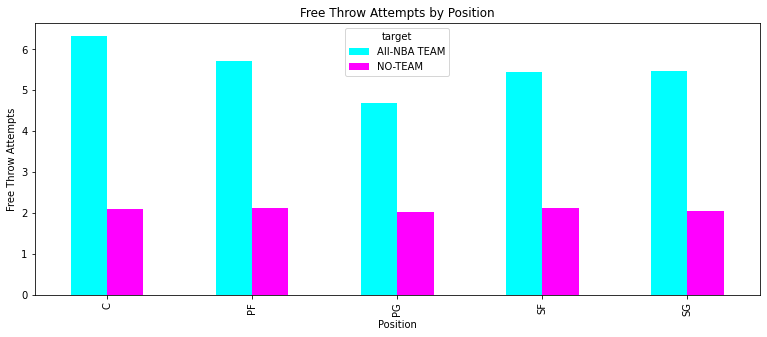

In [124]:
df_grouped = dfeda.groupby(['POS','target'])['FTA'].mean()
df_grouped.unstack().plot(kind='bar',stacked=False,  colormap='cool', grid=False, figsize=(13,5))

plt.title("Free Throw Attempts by Position")
plt.xlabel("Position")

plt.ylabel("Free Throw Attempts")

Text(0, 0.5, 'TRB%')

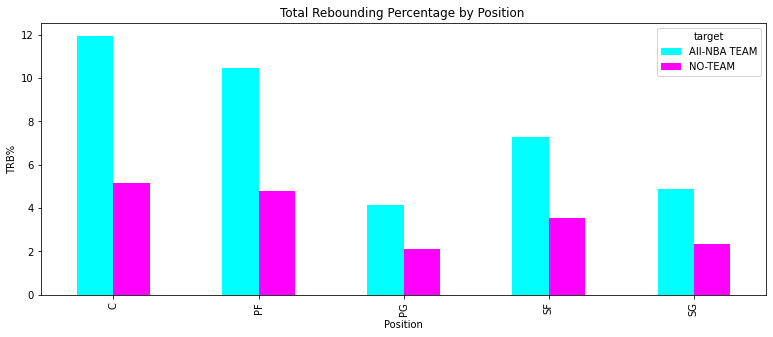

In [125]:
df_grouped = dfeda.groupby(['POS','target'])['TRB'].mean()
df_grouped.unstack().plot(kind='bar',stacked=False,  colormap='cool', grid=False, figsize=(13,5))

plt.title("Total Rebounding Percentage by Position ")
plt.xlabel("Position")

plt.ylabel("TRB%")

## Preprocessing

In [126]:
def missing(row): 
    if (row['3P%']==0):
        return 1
    else:
        return 0

In [127]:
df['missing_3P']= df.apply(lambda row : missing(row), axis=1)

In [128]:
def missing(row): 
    if (row['GS']==0):
        return 1
    else:
        return 0

In [129]:
df['missing_GS']= df.apply(lambda row : missing(row), axis=1)

In [130]:
X=df.drop(['target','1ST_TEAMNBA','2nd_TEAMNBA','3rd_TEAMNBA'],axis=1)
y=df['target']

In [131]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2,random_state=42, stratify=y)

In [132]:
cat_columns= [col for col in X.columns if X[col].dtype in ['object']]
num_columns = [col for col in X.columns if X[col].dtypes in ['float64', 'int64']]


In [133]:
zero_pipe=Pipeline(steps= [('imputer1',SimpleImputer(strategy='median')),
    ('ss', StandardScaler())
])

In [134]:
cat_pipe=Pipeline(steps= [('imputer',SimpleImputer(strategy='constant',fill_value='missing')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [135]:
coltran= ColumnTransformer(transformers=[
    ('zero', zero_pipe , num_columns), 
    ('cat_pipe', cat_pipe, cat_columns)
],remainder= 'passthrough')


In [136]:
#preparing cleaned dataset for all post modeling

In [137]:
coltran.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('zero',
                                 Pipeline(steps=[('imputer1',
                                                  SimpleImputer(strategy='median')),
                                                 ('ss', StandardScaler())]),
                                 ['AGE', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
                                  '3P', '3PA', '3P%', '2P', '2PA', '2P%',
                                  'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
                                  'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                                  'PTS', 'SEASON_COUNT', 'missing_3P',
                                  'missing_GS']),
                                ('cat_pipe',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='co

In [138]:
X_cleaned_train= coltran.transform(X_train)

In [139]:
X_cleaned_test = coltran.transform(X_test)

In [140]:
#the order of the column name has to match the order of the column transformer
cat_columns = coltran.named_transformers_['cat_pipe']['ohe'].get_feature_names(cat_columns).tolist()
all_columns = num_columns + cat_columns 

cleaned_df_train = pd.DataFrame(X_cleaned_train, columns=all_columns)
cleaned_df_test = pd.DataFrame(X_cleaned_test, columns=all_columns)

In [141]:
cleaned_df_train[num_columns].describe()

,AGE,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,TRB,AST,STL,BLK,TOV,PF,PTS,SEASON_COUNT,missing_3P,missing_GS
count,2.136000e+03,2.136000e+03,2.136000e+03,2.136000e+03,2.136000e+03,2.136000e+03,2.136000e+03,2.136000e+03,2.136000e+03,2.136000e+03,...,2.136000e+03,2.136000e+03,2.136000e+03,2.136000e+03,2.136000e+03,2.136000e+03,2.136000e+03,2136.0,2.136000e+03,2.136000e+03
mean,1.398694e-16,-6.278789e-17,-7.448266e-17,-2.894065e-16,-2.988662e-18,2.079459e-16,3.153786e-16,1.578014e-16,1.940811e-16,-2.380534e-17,...,2.042946e-16,1.323588e-16,-2.952278e-17,4.859825e-17,-1.499009e-16,-7.594840e-16,-2.154566e-16,0.0,1.638826e-16,3.666959e-16
std,1.000234e+00,1.000234e+00,1.000234e+00,1.000234e+00,1.000234e+00,1.000234e+00,1.000234e+00,1.000234e+00,1.000234e+00,1.000234e+00,...,1.000234e+00,1.000234e+00,1.000234e+00,1.000234e+00,1.000234e+00,1.000234e+00,1.000234e+00,0.0,1.000234e+00,1.000234e+00
min,-2.939114e+00,-1.862986e+00,-7.017642e-01,-1.954779e+00,-1.395515e+00,-1.491748e+00,-4.370703e+00,-5.952934e-01,-6.639285e-01,-1.765622e+00,...,-1.301121e+00,-1.049143e+00,-1.415008e+00,-8.264782e-01,-1.601200e+00,-2.175885e+00,-1.392867e+00,0.0,-4.350972e-01,-4.983902e-01
25%,-6.437036e-01,-9.079069e-01,-6.205325e-01,-8.064643e-01,-7.586604e-01,-7.604811e-01,-3.509995e-01,-5.952934e-01,-5.878433e-01,-2.278416e-01,...,-7.019843e-01,-7.070626e-01,-5.180035e-01,-6.257097e-01,-5.838997e-01,-7.182108e-01,-7.581773e-01,0.0,-4.350972e-01,-4.983902e-01
50%,-6.985097e-02,3.226764e-01,-4.580691e-01,-1.116854e-01,-2.491765e-01,-2.120309e-01,6.604471e-02,-3.919110e-01,-4.356730e-01,1.890676e-01,...,-2.692747e-01,-3.079686e-01,-2.937523e-01,-2.241727e-01,-2.024122e-01,1.062644e-02,-2.374066e-01,0.0,-4.350972e-01,-4.983902e-01
75%,5.040016e-01,9.287846e-01,1.511685e-01,8.339858e-01,5.575065e-01,6.055662e-01,4.931382e-01,1.485377e-02,1.730082e-01,4.299864e-01,...,3.964322e-01,3.761926e-01,3.790013e-01,1.773643e-01,4.334003e-01,7.394637e-01,5.437495e-01,0.0,-4.350972e-01,-4.983902e-01
max,7.390233e+00,1.296123e+00,2.628735e+00,2.725328e+00,7.095884e+00,6.531876e+00,5.678556e+00,6.523091e+00,5.803310e+00,5.068956e+00,...,7.253214e+00,5.564415e+00,5.761030e+00,1.041656e+01,4.375438e+00,2.821856e+00,6.809272e+00,0.0,2.298337e+00,2.006460e+00


## Modeling

In [142]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(cleaned_df_train, y_train)
dummy_clf.score(cleaned_df_train, y_train)

0.9218164794007491

Will run cross val scores and create confusion matrices. During Grid search look to maximize recall score. 

In [143]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    print(classification_report(y, y_pred))
    plot_confusion_matrix(model, X, y,cmap="Blues")

In [144]:
dt_pipe= Pipeline(steps= [('col', coltran), ('dt',DecisionTreeClassifier())])

In [145]:
dt_pipe.fit(X_train, y_train)

Pipeline(steps=[('col',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('zero',
                                                  Pipeline(steps=[('imputer1',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['AGE', 'G', 'GS', 'MP', 'FG',
                                                   'FGA', 'FG%', '3P', '3PA',
                                                   '3P%', '2P', '2PA', '2P%',
                                                   'eFG%', 'FT', 'FTA', 'FT%',
                                                   'ORB', 'DRB', 'TRB', 'AST',
                                                   'STL', 'BLK', 'TOV', 'PF',
                                           

In [146]:
score= cross_val_score(dt_pipe, X_train, y_train)

In [147]:
score.mean()

0.9068353432992625

In [148]:
dt_pipe.score(X_test, y_test)

0.9063670411985019

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1969
           1       1.00      1.00      1.00       167

    accuracy                           1.00      2136
   macro avg       1.00      1.00      1.00      2136
weighted avg       1.00      1.00      1.00      2136



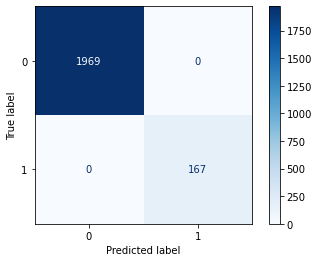

In [149]:
#Though I ran accuracy score above that was just to see the value. Will instead analyze the score report below.
#Will look 
evaluate_model(dt_pipe, X_train, y_train)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       492
           1       0.41      0.45      0.43        42

    accuracy                           0.91       534
   macro avg       0.68      0.70      0.69       534
weighted avg       0.91      0.91      0.91       534



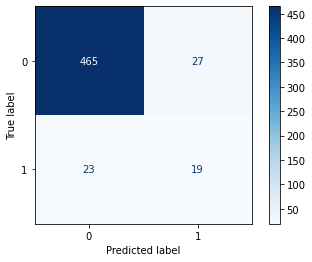

In [150]:
evaluate_model(dt_pipe, X_test, y_test)

In [151]:
#Results show overfitting for train score relative to test. The recall and f1 scores for this Decision tree model
#were .4 and .38. Relaly low and needs to be imporoved

## SMOTE PLUS DECISION TREE MODEL

In [152]:
pipe_model = imbpipeline(steps=[
    ('col', coltran),
    ('smote', SMOTE()),
    ('dt', DecisionTreeClassifier())
])

In [153]:
pipe_model.fit(X_train, y_train)


Pipeline(steps=[('col',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('zero',
                                                  Pipeline(steps=[('imputer1',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['AGE', 'G', 'GS', 'MP', 'FG',
                                                   'FGA', 'FG%', '3P', '3PA',
                                                   '3P%', '2P', '2PA', '2P%',
                                                   'eFG%', 'FT', 'FTA', 'FT%',
                                                   'ORB', 'DRB', 'TRB', 'AST',
                                                   'STL', 'BLK', 'TOV', 'PF',
                                           

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1969
           1       1.00      1.00      1.00       167

    accuracy                           1.00      2136
   macro avg       1.00      1.00      1.00      2136
weighted avg       1.00      1.00      1.00      2136



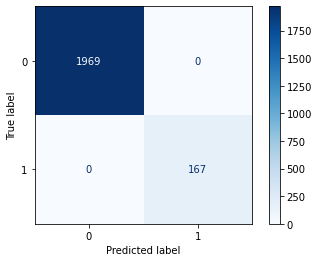

In [154]:
evaluate_model(pipe_model, X_train, y_train)

              precision    recall  f1-score   support

           0       0.94      0.89      0.92       492
           1       0.23      0.38      0.29        42

    accuracy                           0.85       534
   macro avg       0.59      0.64      0.60       534
weighted avg       0.89      0.85      0.87       534



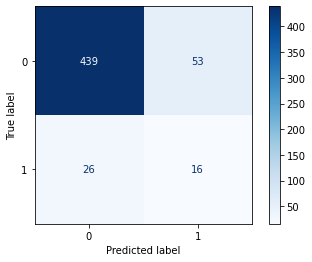

In [155]:
evaluate_model(pipe_model, X_test, y_test)

In [156]:
#slightly imporved recall. Smote did not help much


## Grid Search and smote 

In [197]:
param_grid = {'dt__criterion' :['gini', 'entropy'],
    'dt__max_depth': [None, 5, 9]
}

grid = GridSearchCV(pipe_model, param_grid, scoring='f1', verbose=2)
grid.fit(X_train, y_train)

grid.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] dt__criterion=gini, dt__max_depth=None ..........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........... dt__criterion=gini, dt__max_depth=None, total=   0.2s
[CV] dt__criterion=gini, dt__max_depth=None ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ........... dt__criterion=gini, dt__max_depth=None, total=   0.3s
[CV] dt__criterion=gini, dt__max_depth=None ..........................
[CV] ........... dt__criterion=gini, dt__max_depth=None, total=   0.3s
[CV] dt__criterion=gini, dt__max_depth=None ..........................
[CV] ........... dt__criterion=gini, dt__max_depth=None, total=   0.2s
[CV] dt__criterion=gini, dt__max_depth=None ..........................
[CV] ........... dt__criterion=gini, dt__max_depth=None, total=   0.3s
[CV] dt__criterion=gini, dt__max_depth=5 .............................
[CV] .............. dt__criterion=gini, dt__max_depth=5, total=   0.1s
[CV] dt__criterion=gini, dt__max_depth=5 .............................
[CV] .............. dt__criterion=gini, dt__max_depth=5, total=   0.1s
[CV] dt__criterion=gini, dt__max_depth=5 .............................
[CV] .............. dt__criterion=gini, dt__max_depth=5, total=   0.1s
[CV] dt__criterion=gini, dt__max_depth=5 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    4.1s finished


{'dt__criterion': 'entropy', 'dt__max_depth': 5}

In [198]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__criterion,param_dt__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.236510,0.024800,0.008683,0.006587,gini,None,"{'dt__criterion': 'gini', 'dt__max_depth': None}",0.371429,0.281690,0.285714,0.390244,0.307692,0.327354,0.044952,6
1,0.080354,0.008054,0.004935,0.005924,gini,5,"{'dt__criterion': 'gini', 'dt__max_depth': 5}",0.536585,0.396226,0.437500,0.421053,0.427350,0.443743,0.048374,4
2,0.109589,0.007790,0.006249,0.007653,gini,9,"{'dt__criterion': 'gini', 'dt__max_depth': 9}",0.473684,0.390244,0.481013,0.554217,0.414414,0.462714,0.057294,2
3,0.148101,0.011588,0.015644,0.000024,entropy,None,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.492308,0.219178,0.328767,0.493827,0.390244,0.384865,0.103966,5
4,0.098731,0.002352,0.003118,0.006236,entropy,5,"{'dt__criterion': 'entropy', 'dt__max_depth': 5}",0.446809,0.431373,0.543478,0.456522,0.485981,0.472832,0.039562,1
5,0.129941,0.007714,0.001409,0.002818,entropy,9,"{'dt__criterion': 'entropy', 'dt__max_depth': 9}",0.459459,0.404494,0.432432,0.466667,0.471698,0.446950,0.025183,3


In [199]:
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

Pipeline(steps=[('col',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('zero',
                                                  Pipeline(steps=[('imputer1',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['AGE', 'G', 'GS', 'MP', 'FG',
                                                   'FGA', 'FG%', '3P', '3PA',
                                                   '3P%', '2P', '2PA', '2P%',
                                                   'eFG%', 'FT', 'FTA', 'FT%',
                                                   'ORB', 'DRB', 'TRB', 'AST',
                                                   'STL', 'BLK', 'TOV', 'PF',
                                           

              precision    recall  f1-score   support

           0       0.97      0.85      0.91       492
           1       0.29      0.74      0.42        42

    accuracy                           0.84       534
   macro avg       0.63      0.79      0.66       534
weighted avg       0.92      0.84      0.87       534



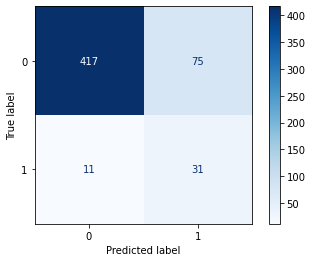

In [200]:
evaluate_model(best_model, X_test, y_test)

In [201]:
#.74 recall  score on this model. Though f1 is relatively low. This ends up being the best model!



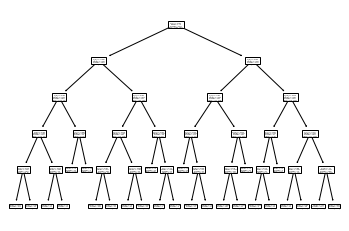

In [202]:
fig, axes = plt.subplots()
plot_tree(best_model['dt'])
plt.show()

In [203]:
#top features forr decision tree and smote 

In [204]:
cat_columns= [col for col in X.columns if X[col].dtype in ['object']]

cat_ohe_cols = best_model.named_steps['col'].named_transformers_['cat_pipe']['ohe'].get_feature_names(cat_columns).tolist()

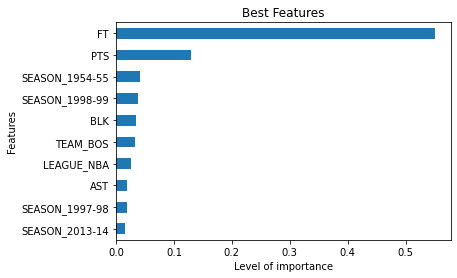

In [205]:
feat_cols = num_columns+ cat_ohe_cols 

X_train_tf = pd.DataFrame(best_model.named_steps['col'].fit_transform(X_train), columns=all_columns)


important_feats = pd.Series(best_model.named_steps['dt'].feature_importances_, 
                           index=feat_cols)

important_feats.sort_values(ascending=False)[:5]

top_feats = important_feats.sort_values(ascending=False).head(10)
plt.Figure(figsize=(5, 5))
top_feats.sort_values().plot(kind='barh')
plt.xlabel('Level of importance')
plt.ylabel('Features')
plt.title('Best Features');


In [206]:
#feature selection 

In [207]:

threshold_ranges= np.linspace(0,1, num=6)

for thresh in threshold_ranges:
    selector = VarianceThreshold(thresh)
    reduce_featrue_train= selector.fit_transform(cleaned_df_train)
    reduce_featrue_test= selector.transform(cleaned_df_test)
    base2 = DecisionTreeClassifier()
    base2.fit(reduce_featrue_train, y_train)
    print(base2.score(reduce_featrue_train, y_train))
    print(base2.score(reduce_featrue_test, y_test))
    print("\n")

1.0
0.9082397003745318


1.0
0.900749063670412


1.0
0.9101123595505618


1.0
0.898876404494382


1.0
0.9082397003745318


0.9995318352059925
0.9101123595505618




In [208]:
cleaned_df_train[cleaned_df_train.columns[selector.get_support(indices=True)]]

,AGE,FG,FGA,3P,eFG%,FT,ORB,AST,BLK,PF,PTS,missing_GS
0,-0.069851,0.217851,0.214541,2.048678,0.632268,-0.279816,0.235765,0.889313,1.582744,0.427105,0.267090,-0.49839
1,-1.791409,0.260308,0.316106,1.641913,0.295908,-0.144944,-0.689959,0.148139,-0.224173,-0.822330,0.283364,-0.49839
2,-0.643704,-0.588832,-0.455787,-0.595293,-1.008759,-0.077507,0.235765,-0.821089,0.378133,0.843583,-0.514066,2.00646
3,1.077854,-0.588832,-0.516725,-0.595293,-0.672399,-0.347252,-0.111382,-0.307969,-0.023404,-0.718211,-0.562888,-0.49839
4,-0.069851,0.345222,0.600488,1.438531,-0.193342,1.473526,0.235765,0.433206,0.177364,-0.509972,0.739038,-0.49839
...,...,...,...,...,...,...,...,...,...,...,...,...
2131,-1.217556,-1.140773,-1.268305,-0.391911,0.092054,-1.089051,-0.227097,-0.821089,-0.224173,-1.759407,-1.165029,-0.49839
2132,-1.217556,-1.098316,-1.288618,-0.595293,2.059248,-1.156487,-0.921390,-0.878103,-0.826478,-1.134689,-1.181303,-0.49839
2133,0.504002,2.722813,2.834915,-0.391911,-0.091415,4.170976,0.698627,1.060354,-0.224173,1.155942,3.066233,-0.49839
2134,-1.791409,0.939619,0.823931,2.658825,0.866700,0.394546,0.814343,-0.136928,0.378133,0.322985,1.015698,-0.49839


### tree pruning and variance threshold data 

In [169]:
clf = DecisionTreeClassifier()

In [170]:
path = clf.cost_complexity_pruning_path(reduce_featrue_train, y_train)

In [171]:
ccp_alphas = path.ccp_alphas

In [172]:
ccp_alphas = ccp_alphas[:-1]

In [173]:
clfs= []


In [174]:
for ccp_alpha in ccp_alphas: 
    clf =DecisionTreeClassifier(random_state =0, ccp_alpha= ccp_alpha)
    clf.fit(reduce_featrue_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 3 with ccp_alpha: 0.004079986553869215


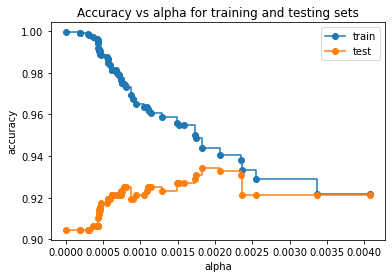

In [175]:
train_scores = [clf.score(reduce_featrue_train, y_train) for clf in clfs]
test_scores = [clf.score(reduce_featrue_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [176]:
clf_pruned = DecisionTreeClassifier(random_state = 42, ccp_alpha= 0.0020)
clf_pruned = clf_pruned.fit(reduce_featrue_train, y_train)

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       492
           1       0.68      0.31      0.43        42

    accuracy                           0.93       534
   macro avg       0.81      0.65      0.70       534
weighted avg       0.92      0.93      0.92       534



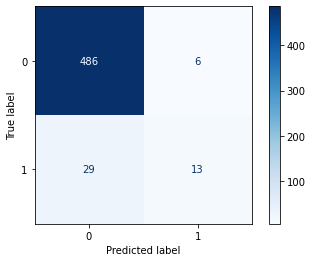

In [177]:
evaluate_model(clf_pruned,reduce_featrue_test, y_test)

In [178]:
#This made our models worse. Not optimal

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1969
           1       0.77      0.40      0.53       167

    accuracy                           0.94      2136
   macro avg       0.86      0.70      0.75      2136
weighted avg       0.94      0.94      0.94      2136



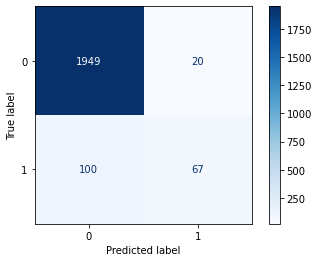

In [179]:
evaluate_model(clf_pruned,reduce_featrue_train, y_train)


In [180]:
#NOT GREAT RESULTS TRYING TO PRUNE

## Random Forest Model 

In [181]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#pipeline - random forest
forest_pipe = imbpipeline(steps=[
    ('coltran', coltran),
    ('smote', SMOTE()),
    ('forest', RandomForestClassifier())
])

#random forest baseline model
%time
forest_pipe.fit(X_train, y_train)
forest_pipe.score(X_train, y_train)

Wall time: 0 ns


1.0

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       492
           1       0.52      0.55      0.53        42

    accuracy                           0.93       534
   macro avg       0.74      0.75      0.75       534
weighted avg       0.93      0.93      0.93       534



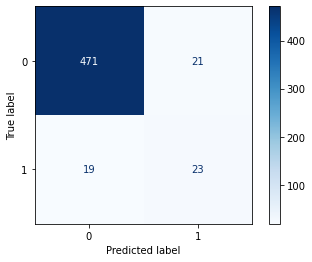

In [182]:
evaluate_model(forest_pipe, X_test, y_test)

In [183]:
# Recall and F1 lower than SMOTE DECISION TREE MODEL. 

## XG BOOSTING MODEL

In [184]:
#pipeline - xg boosting
from xgboost import XGBClassifier
xg_pipe = imbpipeline(steps=[
    ('coltran', coltran),
    ('smote', SMOTE()),
    ('xg', XGBClassifier())
])

#xg boosting baseline model
%time
xg_pipe.fit(X_train, y_train)
xg_pipe.score(X_train, y_train)

Wall time: 0 ns


1.0

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       492
           1       0.53      0.43      0.47        42

    accuracy                           0.93       534
   macro avg       0.74      0.70      0.72       534
weighted avg       0.92      0.93      0.92       534



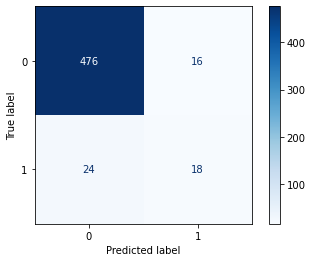

In [185]:
evaluate_model(xg_pipe, X_test, y_test)

## Gradient Boosting Model

In [186]:
#pipeline - gradient boosting
gb_pipe = imbpipeline(steps=[
    ('coltran', coltran),
    ('smote', SMOTE()),
    ('gb', GradientBoostingClassifier())
])

#gradient boosting baseline model
%time
gb_pipe.fit(X_train, y_train)
gb_pipe.score(X_train, y_train)

Wall time: 0 ns


0.9536516853932584

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       492
           1       0.48      0.71      0.58        42

    accuracy                           0.92       534
   macro avg       0.73      0.82      0.77       534
weighted avg       0.94      0.92      0.92       534



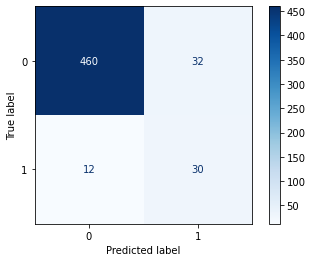

In [187]:
evaluate_model(gb_pipe, X_test, y_test)


Gradient Boosting Model had second best f1 and recall scores. 

In [188]:
#random forest grid 1
forest_param_grid1 = {
    'forest__max_depth': [20, 30],
    'forest__min_samples_split': [2, 3, 5],
    'forest__min_samples_leaf': [1, 2]
}

gs_forest1 = GridSearchCV(forest_pipe, forest_param_grid1,scoring='f1', cv=2)

%time
gs_forest1.fit(X_train, y_train)

gs_forest1.best_params_

Wall time: 0 ns


{'forest__max_depth': 30,
 'forest__min_samples_leaf': 2,
 'forest__min_samples_split': 2}

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1969
           1       0.94      1.00      0.97       167

    accuracy                           1.00      2136
   macro avg       0.97      1.00      0.98      2136
weighted avg       1.00      1.00      1.00      2136



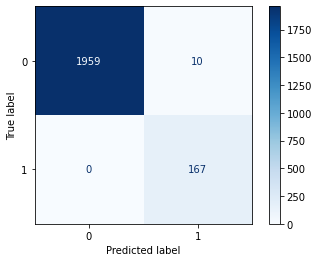

In [189]:
#classification report
evaluate_model(gs_forest1.best_estimator_, X_train, y_train)

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       492
           1       0.48      0.57      0.52        42

    accuracy                           0.92       534
   macro avg       0.72      0.76      0.74       534
weighted avg       0.92      0.92      0.92       534



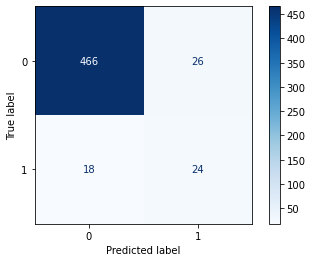

In [190]:
evaluate_model(gs_forest1.best_estimator_, X_test, y_test)

 Gridsearch Decision Tree model along with SMOTe ended up being the best result.

In [217]:
youngplayers.head()

,SEASON,AGE,TEAM,LEAGUE,POS,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PLAYER,SEASON_COUNT
0,2020-21,19.0,GSW,NBA,C,39,27,21.4,4.9,9.4,...,4.4,5.8,0.7,0.3,0.9,1.5,3.1,11.5,James Wiseman,1
0,2020-21,19.0,DET,NBA,PG,26,18,25.8,2.7,7.7,...,2.4,2.7,5.3,1.0,0.4,3.2,2.2,6.8,Killian Hayes,1
0,2020-21,20.0,SAC,NBA,PG,58,20,30.1,5.0,10.7,...,2.3,3.0,5.3,1.3,0.5,1.6,1.4,13.0,Tyrese Haliburton,1
0,2020-21,19.0,CHO,NBA,PG,51,31,28.8,5.7,13.2,...,4.7,5.9,6.1,1.6,0.4,2.8,2.7,15.7,LaMelo Ball,1
0,2020-21,19.0,OKC,NBA,PF,45,28,24.2,3.1,9.1,...,4.0,4.7,2.2,0.4,0.9,2.2,1.3,8.2,Aleksej Pokusevski,1


In [214]:
youngplayers.columns

Index(['SEASON', 'AGE', 'TEAM', 'LEAGUE', 'POS', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'PLAYER', 'SEASON_COUNT'],
      dtype='object')

In [225]:
season2=youngplayers.loc[youngplayers.SEASON_COUNT >1]


In [228]:
season2

,SEASON,AGE,TEAM,LEAGUE,POS,G,GS,MP,FG,FGA,...,AST,STL,BLK,TOV,PF,PTS,PLAYER,SEASON_COUNT,missing_3P,missing_GS
1,2020-21,19.0,DEN,NBA,PG,25.0,0.0,9.3,1.0,2.4,...,0.6,0.2,0.1,0.4,0.9,2.6,R.J. Hampton,2,1,1
1,2020-21,22.0,HOU,NBA,SG,26.0,1.0,11.8,1.8,4.4,...,1.5,0.2,0.0,1.1,0.8,5.8,Mason Jones,2,0,0
1,2020-21,24.0,HOU,NBA,SG,4.0,0.0,6.0,0.5,1.8,...,1.0,0.3,0.3,1.0,1.3,2.5,Brodric Thomas,2,1,1
1,2020-21,24.0,MIL,NBA,PG,7.0,0.0,2.6,0.1,1.1,...,0.3,0.0,0.0,0.0,0.1,0.3,Jaylen Adams,2,1,1
1,2018-19,21.0,MIA,NBA,C,82,28,23.3,3.4,5.9,...,2.2,0.9,0.8,1.5,2.5,8.9,Bam Adebayo,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,2020-21,20.0,NOP,NBA,PF,61,61,33.2,10.4,17.0,...,3.7,0.9,0.6,2.7,2.2,27.0,Zion Williamson,2,0,0
1,2018-19,22.0,MIL,NBA,PF,48.0,3.0,18.4,2.2,5.2,...,1.1,0.4,0.4,0.7,1.8,5.8,D.J. Wilson,2,0,0
1,2018-19,23.0,BOS,NBA,PF,41,1,6.1,0.9,1.9,...,0.4,0.2,0.2,0.4,0.8,2.3,Guerschon Yabusele,2,0,0
1,2019-20,21.0,ATL,NBA,PG,60,60,35.3,9.1,20.8,...,9.3,1.1,0.1,4.8,1.7,29.6,Trae Young,2,0,0


In [167]:
#season2.reset_index()

In [219]:
#season2.drop('PLAYER', axis=1)

In [226]:
season2['missing_3P']= season2.apply(lambda row : missing(row), axis=1)

<ipython-input-226-755d9ccb59f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season2['missing_3P']= season2.apply(lambda row : missing(row), axis=1)


In [227]:
season2['missing_GS']= season2.apply(lambda row : missing(row), axis=1)

<ipython-input-227-7daa72ceb066>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season2['missing_GS']= season2.apply(lambda row : missing(row), axis=1)


In [229]:
season2.set_index('PLAYER', inplace=True)

In [230]:
season2.head()

,SEASON,AGE,TEAM,LEAGUE,POS,G,GS,MP,FG,FGA,...,TRB,AST,STL,BLK,TOV,PF,PTS,SEASON_COUNT,missing_3P,missing_GS
PLAYER,,,,,,,,,,,,,,,,,,,,,
R.J. Hampton,2020-21,19.0,DEN,NBA,PG,25.0,0.0,9.3,1.0,2.4,...,2.0,0.6,0.2,0.1,0.4,0.9,2.6,2,1,1
Mason Jones,2020-21,22.0,HOU,NBA,SG,26.0,1.0,11.8,1.8,4.4,...,2.0,1.5,0.2,0.0,1.1,0.8,5.8,2,0,0
Brodric Thomas,2020-21,24.0,HOU,NBA,SG,4.0,0.0,6.0,0.5,1.8,...,1.0,1.0,0.3,0.3,1.0,1.3,2.5,2,1,1
Jaylen Adams,2020-21,24.0,MIL,NBA,PG,7.0,0.0,2.6,0.1,1.1,...,0.4,0.3,0.0,0.0,0.0,0.1,0.3,2,1,1
Bam Adebayo,2018-19,21.0,MIA,NBA,C,82,28,23.3,3.4,5.9,...,7.3,2.2,0.9,0.8,1.5,2.5,8.9,2,0,0


In [234]:
yhats=best_model.predict(season2)

In [236]:
season2['predicted_target'] = yhats

<ipython-input-236-e03a744d9b54>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season2['predicted_target'] = yhats


In [237]:
season2

,SEASON,AGE,TEAM,LEAGUE,POS,G,GS,MP,FG,FGA,...,AST,STL,BLK,TOV,PF,PTS,SEASON_COUNT,missing_3P,missing_GS,predicted_target
PLAYER,,,,,,,,,,,,,,,,,,,,,
R.J. Hampton,2020-21,19.0,DEN,NBA,PG,25.0,0.0,9.3,1.0,2.4,...,0.6,0.2,0.1,0.4,0.9,2.6,2,1,1,0
Mason Jones,2020-21,22.0,HOU,NBA,SG,26.0,1.0,11.8,1.8,4.4,...,1.5,0.2,0.0,1.1,0.8,5.8,2,0,0,0
Brodric Thomas,2020-21,24.0,HOU,NBA,SG,4.0,0.0,6.0,0.5,1.8,...,1.0,0.3,0.3,1.0,1.3,2.5,2,1,1,0
Jaylen Adams,2020-21,24.0,MIL,NBA,PG,7.0,0.0,2.6,0.1,1.1,...,0.3,0.0,0.0,0.0,0.1,0.3,2,1,1,0
Bam Adebayo,2018-19,21.0,MIA,NBA,C,82,28,23.3,3.4,5.9,...,2.2,0.9,0.8,1.5,2.5,8.9,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zion Williamson,2020-21,20.0,NOP,NBA,PF,61,61,33.2,10.4,17.0,...,3.7,0.9,0.6,2.7,2.2,27.0,2,0,0,1
D.J. Wilson,2018-19,22.0,MIL,NBA,PF,48.0,3.0,18.4,2.2,5.2,...,1.1,0.4,0.4,0.7,1.8,5.8,2,0,0,0
Guerschon Yabusele,2018-19,23.0,BOS,NBA,PF,41,1,6.1,0.9,1.9,...,0.4,0.2,0.2,0.4,0.8,2.3,2,0,0,0


In [239]:
season2[season2['predicted_target']>0]

,SEASON,AGE,TEAM,LEAGUE,POS,G,GS,MP,FG,FGA,...,AST,STL,BLK,TOV,PF,PTS,SEASON_COUNT,missing_3P,missing_GS,predicted_target
PLAYER,,,,,,,,,,,,,,,,,,,,,
RJ Barrett,2020-21,20.0,NYK,NBA,SG,72,72,34.9,6.5,14.7,...,3.0,0.7,0.3,1.9,2.6,17.6,2,0,0,1
John Collins,2018-19,21.0,ATL,NBA,PF,61,59,30.0,7.6,13.6,...,2.0,0.4,0.6,2.0,3.3,19.5,2,0,0,1
Luka Doncic,2019-20,20.0,DAL,NBA,PG,61,61,33.6,9.5,20.6,...,8.8,1.0,0.2,4.3,2.5,28.8,2,0,0,1
De'Aaron Fox,2018-19,21.0,SAC,NBA,PG,81,81,31.4,6.2,13.6,...,7.3,1.6,0.6,2.8,2.5,17.3,2,0,0,1
Shai Gilgeous-Alexander,2019-20,21.0,OKC,NBA,SG,70.0,70.0,34.7,6.8,14.5,...,3.3,1.1,0.7,1.9,1.7,19.0,2,0,0,1
Devonte' Graham,2019-20,24.0,CHO,NBA,PG,63,53,35.1,5.8,15.3,...,7.5,1.0,0.2,2.9,1.8,18.2,2,0,0,1
De'Andre Hunter,2020-21,23.0,ATL,NBA,SF,23,19,29.5,5.2,10.8,...,1.9,0.8,0.5,1.3,2.6,15.0,2,0,0,1
Kyle Kuzma,2018-19,23.0,LAL,NBA,PF,70,68,33.1,7.1,15.5,...,2.5,0.6,0.4,1.9,2.4,18.7,2,0,0,1
Lauri Markkanen,2018-19,21.0,CHI,NBA,PF,52,51,32.3,6.6,15.3,...,1.4,0.7,0.6,1.6,2.3,18.7,2,0,0,1


In [ ]:
These are the predicted future All-NBA Team plyers